<h1>Table of content</h1>
<ul>
    <li><a href="#ref1">Introduction / Problem definition </a></li>
    <li><a href="#ref2">Data </a></li>
    <li><a href="#ref3">Methodology </a></li>
    <li><a href="#ref4">Grid Search</a></li>
</ul>

Lets first start with importing all the necesary libraries to run the analysis

In [80]:
import pandas as pd
import numpy as np 
import folium
import json
import math
from shapely.geometry import shape, Point
import requests
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.cluster import KMeans



# 1 Data preparation
## GeoJson data:
The data obtained from the British government provides all the boundaries of all British Local Authority Areas. Since the analysis is focused in London a modification in the file is needed dropping all the areas that are not within London metropolitan Area. This can be easyly recognized because they are between E09000001 and E09000033. In future, this new file will be used to exclude any venues that are outside London and to display the chlorophet map with only the boroughs in the analysis

In [2]:
# Create a list with only the codes from the London Metropolitan Area
LondonBoroughsCodes = list(range(9000001,9000034))
LondonBoroughs = []
for item in LondonBoroughsCodes:
    LondonBoroughs.append('E0{}'.format(item))
 


In [ ]:
#Delete features for non Local Authorities outside Lonodon Area. Open the file, loop throw all the features an keep only the ones belonging to London Authority area
with open('Local_Authority_Districts__December_2017__Boundaries_in_the_UK__WGS84_.geojson', 'r') as f_in:
    data2 = json.load(f_in)
    features_filtered=[]
    for i in range(len(data2['features'])):
        if data2['features'][i]['properties']['lad17cd']  in LondonBoroughs:
            features_filtered.append(data2['features'][i])
            
    data2['features'] = features_filtered  
    with open('London_Boroughs_Boundaries.geojson', 'w') as f_out:
        json.dump(data2, f_out)
        print('File London_Boroughs_Boundaries.geojson created')





## Foursquare data:
The objective is to obtain all the venues of the selected categories that are inside the London metropolitan Area. The challenge in this is the limits in number of requests and number of venues in the results that Foursquare set for free accounts. A Foursquare request, centred in the centre of London with a radius large enough to cover all the metropolitan area and with all the categories we are interested could be used, however only 50 venues would be retrieved due to Foursquare limits. To ensure that all the venues of each category are retrieved from the Foursquare database a sweep of the London metropolitan area with circles of a radius small enough to not saturate the request with over 50 results is used. Going further a sweep of the area looking for venues of only one particular category is done. In that way the number of sweeps to the London metropolitan area will match exactly the number of distinct types of venues that the target audience of the analysis are interested in.

### Creation of the mesh of points

Foursquare only allows to get venues by giving it a centre and a radius. In this way we need to create a mesh of points (Longitude, Latitude) that will be used as centres in the Foursquare request and that will cover the entire area of all London neighbourhoods. The layout of circles that will cover the area with less overlapping zones is similar to the one in the next picture.

<img src=https://upload.wikimedia.org/wikipedia/commons/c/c6/Circle_covering_-_Hexagonal_pattern.png>

The distance between the centerpoints of each circle in function of the radious are defined by the next expressions:

<img src=mesh_definition.jpg>

Once the distance between points is known we only need to define where to place the mesh. The answer to that lies with the GeoJson data from the previous step: by checking what are the minimum and maximum values of the coordinates longitude and latitude of the geographical points defining the boundary of all the neighbourhoods of London we obtain the 4 vertex of the rectangle that set the boundaries of the mesh



In [10]:
#Creation a df with all the points in the london boroughs boundaries to obtain min and max Long and Lat. 
boroughs_boundary = []
with open('London_Boroughs_Boundaries.geojson') as f:
    data = json.load(f)
    for element in data['features']:
        if element['properties']['lad17cd']  in LondonBoroughs:
            for coordinategroup in element['geometry']['coordinates']:
                for coordinate in coordinategroup:
                    boroughs_boundary.append([[element['properties']['lad17cd'], coordinate[0], coordinate[1]]])

boroughs_boundary_df = pd.DataFrame([item for element in boroughs_boundary for item in element])
boroughs_boundary_df.columns = ['Borough_code', 'Longitude', 'Latitude']

min_long=boroughs_boundary_df['Longitude'].min()
max_long=boroughs_boundary_df['Longitude'].max()
min_lat=boroughs_boundary_df['Latitude'].min()
max_lat=boroughs_boundary_df['Latitude'].max()

print('The number of geographycal points definining the boundaries of London is {}'.format(boroughs_boundary_df.shape[0]))
print('The metropolitan area of london is between {}  and {} degrees Latitude and {} and {} degreees Longitude'.format(min_lat, max_lat, min_long, max_long))
#create a new geometry by merging all London boroughs into one area



The number of geographycal points definining the boundaries of London is 1272
The metropolitan area of london is between 51.287296026000035  and 51.69236207100005 degrees Latitude and -0.511281856999972 and 0.332213805000038 degreees Longitude


The conversion from km to coordinates Lat, Long is:

Latitude: 1 deg = 110.574 km

Longitude: 1 deg = 111.320*cos(latitude) km

In [11]:
#The next piece of code will generate a mesh of geo points that will cover the whole are of London
radius = 2.5 #radio en km
delta_longitude = math.sqrt(3)*radius/(111.32*math.cos(math.radians(boroughs_boundary_df['Latitude'].mean())))
delta_latitude = 3*radius/110.574

mesh_points = []
#To ensure we cover the entire area we start 1 step before the min long and lat and we go another step after the maximuns
for i in range(-1, int((max_long - min_long)/delta_longitude)+2):
    for j in range(-1, int((max_lat - min_lat)/delta_latitude)+2):
        mesh_points.append([min_lat + j*delta_latitude, min_long + i*delta_longitude])
        mesh_points.append([min_lat + delta_latitude/2 +j*delta_latitude, min_long +delta_longitude/2 + i*delta_longitude])
print('Mesh for London area created')
London_lat=boroughs_boundary_df['Latitude'].mean()
London_lon=boroughs_boundary_df['Longitude'].mean()


Mesh for London area created


In [ ]:
#The next  piece of code draw the mesh created in a map with the London area identified
map_london = folium.Map(location=[London_lat, London_lon], zoom_start=10, tiles='openstreetmap')
map_london.choropleth(
    geo_data='London_Boroughs_Boundaries.geojson',
    
    fill_color='orange', 
    fill_opacity=0.4, 
    line_opacity=0.6,
    legend_name='London Boroughs'
)

for point in mesh_points:
   folium.Circle(point, radius= radius*1000, color='green', fill_color='green', fill_opacity=0.3).add_to(map_london)
map_london

For each point in the mesh we are going to check if the vertex of the its hexagon will be inside any london area:

As we can see we cover the whole area of London, however there are a number of circles that are entirely out of any London area.  The next step is to remove them from the mesh. In order to do that a check in 6 points of the its circumference is used to discard any circle with all the 6 points out of London. 

In [ ]:
#Definition of a function that will check if any given geopoint will be inside a given GeoJson file with the boundaries
def check_london_area(geopoint, geojson):
    with open(geojson) as f:
        js = json.load(f)
        point = Point(geopoint[1],geopoint[0])
        # check each polygon to see if it contains the point
        result=False
        for feature in js['features']:
            polygon = shape(feature['geometry'])
            if polygon.contains(point):
                return True
                break
    return result    
mesh_points_within_london = []
#Loop throw all the poinst in the mesh and check for each of them if its hexagon sits in any area of London
for point in mesh_points:
    point_a = [point[0] + radius/110.574, point[1]]
    point_b = [point[0] + radius/(2*110.574), point[1] + math.sqrt(3)*radius/(2*111.32*math.cos(math.radians(boroughs_boundary_df['Latitude'].mean())))]
    point_c = [point[0] - radius/(2*110.574), point[1] + math.sqrt(3)*radius/(2*111.32*math.cos(math.radians(boroughs_boundary_df['Latitude'].mean())))]
    point_d = [point[0] - radius/110.574, point[1]]
    point_e = [point[0] + radius/(2*110.574), point[1] - math.sqrt(3)*radius/(2*111.32*math.cos(math.radians(boroughs_boundary_df['Latitude'].mean())))]
    point_f = [point[0] - radius/(2*110.574), point[1] - math.sqrt(3)*radius/(2*111.32*math.cos(math.radians(boroughs_boundary_df['Latitude'].mean())))]
    if check_london_area(point_a, 'London_Boroughs_Boundaries.geojson'):
       mesh_points_within_london.append(point)
    elif check_london_area(point_b, 'London_Boroughs_Boundaries.geojson'):
       mesh_points_within_london.append(point)
    elif check_london_area(point_c, 'London_Boroughs_Boundaries.geojson'):
       mesh_points_within_london.append(point)
    elif check_london_area(point_d, 'London_Boroughs_Boundaries.geojson'):
       mesh_points_within_london.append(point) 
    elif check_london_area(point_e, 'London_Boroughs_Boundaries.geojson'):
       mesh_points_within_london.append(point) 
    elif check_london_area(point_f, 'London_Boroughs_Boundaries.geojson'):
       mesh_points_within_london.append(point)       
    folium.CircleMarker(point_a, radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=0.7, parse_html=False).add_to(map_london)
    folium.CircleMarker(point_b, radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=0.7, parse_html=False).add_to(map_london)
    folium.CircleMarker(point_c, radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=0.7, parse_html=False).add_to(map_london)
    folium.CircleMarker(point_d, radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=0.7, parse_html=False).add_to(map_london)
    folium.CircleMarker(point_e, radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=0.7, parse_html=False).add_to(map_london)
    folium.CircleMarker(point_f, radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=0.7, parse_html=False).add_to(map_london)
map_london


In [ ]:
print('From an original mesh of {} points, only {} fall into London Area and will be considered.'.format(len(mesh_points),len(mesh_points_within_london)))

In [ ]:
#The next piece of code will draw the map with the final mesh used:
map_london_filtered_mesh = folium.Map(location=[London_lat, London_lon], zoom_start=10, tiles='openstreetmap')
map_london_filtered_mesh.choropleth(
    geo_data='London_Boroughs_Boundaries.geojson',
    
    fill_color='orange', 
    fill_opacity=0.4, 
    line_opacity=0.6,
    legend_name='London Boroughs'
)

for point in mesh_points_within_london:
   folium.Circle(point, radius= radius*1000, color='green', fill_color='green', fill_opacity=0.3).add_to(map_london_filtered_mesh)
map_london_filtered_mesh

### Foursquare request

In total 15 different venues categories have been selected for the analysis. They all fall into the main groups that are considered the lead for the project that can be see next including the Foursquare venue category code. This piece of information has been obtained from the Foursquare documentation (*https://developer.foursquare.com/docs/build-with-foursquare/categories/*)

As already mentioned, the way to obtain all the venues of each category from Foursquare will be 2 nested loops, The first one across categories and the second one across all the points in the mesh.
As there are 130 points in the mesh and 15 categories, the number of requests needed is 130 x 15 = 1950. As Foursquare has a limit of 500 calls an hour and 950 calls a day. The exercise of obtaining the venues is done across 3 different days. The results obtained for each category are saved in a csv file. Once all the csv files from the 3 different days are created, they are all combined in 1 data frame


In [3]:
#definition of the Foursquare categories number in a dictionary
categories_group = {
    'Health': {
        'Hospital': '4bf58dd8d48988d196941735',
        'Doctor': '4bf58dd8d48988d177941735',
        'Pharmacy': '4bf58dd8d48988d10f951735'},
    'Transport': {
        'Trains_Platforms': '4f4531504b9074f6e4fb0102',
        'Underground': '4bf58dd8d48988d1fd931735',
        'Light_rail': '4bf58dd8d48988d1fc931735'},
    'Well-Being': {
        'Park': '4bf58dd8d48988d163941735',
        'Pool': '4bf58dd8d48988d15e941735',
        'Gym': '4bf58dd8d48988d175941735'},
    'Dailyneeds': {
        'Fruit_And_Veg_Shop': '52f2ab2ebcbc57f1066b8b1c',
        'Supermarket': '52f2ab2ebcbc57f1066b8b46',
        'Shopping_Mall': '4bf58dd8d48988d1fd941735'},
    'Education':{
        'Elementary_School': '4f4533804b9074f6e4fb0105',
        'Middle_School': '4f4533814b9074f6e4fb0106',
        'Preschool': '52e81612bcbc57f1066b7a45'}

    }
categories_group_1={
    'Health': {
        'Hospital': '4bf58dd8d48988d196941735',
        'Doctor': '4bf58dd8d48988d177941735',
        'Pharmacy': '4bf58dd8d48988d10f951735'},
    'Transport': {
        'Trains_Platforms': '4f4531504b9074f6e4fb0102',
        'Underground': '4bf58dd8d48988d1fd931735',
        'Light_rail': '4bf58dd8d48988d1fc931735'}
    }
categories_group_2={
    'Well-Being': {
        'Park': '4bf58dd8d48988d163941735',
        'Pool': '4bf58dd8d48988d15e941735',
        'Gym': '4bf58dd8d48988d175941735'},
    'Dailyneeds': {
        'Fruit_And_Veg_Shop': '52f2ab2ebcbc57f1066b8b1c',
        'Supermarket': '52f2ab2ebcbc57f1066b8b46',
        'Shopping_Mall': '4bf58dd8d48988d1fd941735'}
    }
categories_group_3={
    'Education':{
        'Elementary_School': '4f4533804b9074f6e4fb0105',
        'Middle_School': '4f4533814b9074f6e4fb0106',
        'Preschool': '52e81612bcbc57f1066b7a45'}

    }


In [ ]:
#The next piece of code initalice the paramenter needed for create a Foursquare request

CLIENT_ID = '3CL45KZFHOK53DH0KIK33CC2YQWHHYSYUFFVCZNMD43OEXL1' # your Foursquare ID
CLIENT_SECRET = 'FSBQZABH0LK45QVXZ1Y0ZUQU421M5SCU5XYMX1ZSIMB54LEC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

#The fucntion getVenues creates a csv file with all the venues for a given category that are in given mesh of points. 
def getVenues(mesh_points, group, category_name, category_code, radius=2000):
    
    venues_list=[]
    for mesh_point in mesh_points:
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(    
            CLIENT_ID, 
            CLIENT_SECRET, 
            mesh_point[0], 
            mesh_point[1], 
            VERSION,
            category_code,
            radius, 
            LIMIT)
        
        # make the GET request
        json_results = requests.get(url).json() #["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        results = json_results['response']['venues']
        
        venues_list.append([(
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            group,
            category_name) for v in results])

    
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        if nearby_venues.shape[0]>0:
            nearby_venues.columns = ['Venue', 
                        'Latitude', 
                        'Longitude',
                        'Group', 
                        'Category']
                        
            nearby_venues.drop_duplicates(inplace=True)
        nearby_venues.to_csv('{}.csv'.format(category_name))


In [ ]:
#Loop to obtain venues - Day 1
for group_name, categories in categories_group_1.items():
    print('Obtaining venues for group {}'.format(group_name))
    for name, code  in categories.items():
        print ('Using code:{} to generate {}.csv'.format(code,name))
        print ('...')
        getVenues(mesh_points_within_london, group_name, name, code, radius*1000 )


In [ ]:
#Loop to obtain venues - Day 2
for group_name, categories in categories_group_2.items():
    print('Obtaining venues for group {}'.format(group_name))
    for name, code  in categories.items():
        print ('Using code:{} to generate {}.csv'.format(code,name))
        print ('...')
        getVenues(mesh_points_within_london, group_name, name, code, radius*1000 )


In [ ]:
#Loop to obtain venues - Day 3
for group_name, categories in categories_group_3.items():
    print('Obtaining venues for group {}'.format(group_name))
    for name, code  in categories.items():
        print ('Using code:{} to generate {}.csv'.format(code,name))
        print ('...')
        getVenues(mesh_points_within_london, group_name, name, code, radius*1000 )


In [4]:
#The next piece of code will import all the csv files generated and compile in one dataframe
dfs=[]
for group_name, categories in categories_group.items():
    for name, code  in categories.items():
        with open ('{}.csv'.format(name), encoding="utf-8") as f:
            print('Importing {}.csv...'.format(name))
            dfs.append(pd.read_csv(f))
london_venues_df=pd.concat(dfs)
print('Total venues loaded in the dataframe {}.'.format(london_venues_df.shape[0]))
london_venues_df.drop(london_venues_df.columns[0], axis=1, inplace=True)
london_venues_df.drop_duplicates(inplace=True)

london_venues_df.head()

Importing Hospital.csv...
Importing Doctor.csv...
Importing Pharmacy.csv...
Importing Trains_Platforms.csv...
Importing Underground.csv...
Importing Light_rail.csv...
Importing Park.csv...
Importing Pool.csv...
Importing Gym.csv...
Importing Fruit_And_Veg_Shop.csv...
Importing Supermarket.csv...
Importing Shopping_Mall.csv...
Importing Elementary_School.csv...
Importing Middle_School.csv...
Importing Preschool.csv...
Total venues loaded in the dataframe 9547.


Venue   Latitude  Longitude   Group  Category
0  Ashford Walk In Health Centre  51.444404  -0.473677  Health  Hospital
1               Ashford Hospital  51.444234  -0.473064  Health  Hospital
2           The education centre  51.439484  -0.478887  Health  Hospital
3        Ashford Xray Department  51.443974  -0.473029  Health  Hospital
4                 Mri Department  51.444120  -0.476276  Health  Hospital

The data retrieved from Foursquare for each venue are the name, geographical coordinates (Long, Lat) and venue category. At this moment we are still missing the neighbourhood that the venue belongs to. To identify it, we will use the GeoJson file created in previous step and define a function that given a point and the GeoJson return the name and code of the neighbourhood.

In [5]:

# The next function will return a list with the name of the borughs for a given set of long lat and the geoJson file 
def find_borough(lats, longs, geojson):
    with open(geojson) as f:
        js = json.load(f)
    boroughs = []
    
    for lat, long, in zip(lats, longs):
        # construct point based on lon/lat returned by geocoder
        point = Point(long, lat)
        result="Out of Geometry" # set the retunr value as out of geometry until it is found in the given geoJson
        
        for feature in js['features']:
            polygon = shape(feature['geometry'])
            if polygon.contains(point):
                result = feature['properties']['lad17nm']
        boroughs.append(result)
    return boroughs
#Defining the Boroguh column in the dataframe using the find_borough function
london_venues_df['Borough'] = find_borough(london_venues_df['Latitude'], london_venues_df['Longitude'], 'London_Boroughs_Boundaries.geojson')

In [6]:
#Drop values that are outside London
london_venues_df = london_venues_df[london_venues_df.Borough!='Out of Geometry']
print('{} venues obtained inside London area'.format(london_venues_df.shape[0]))


8788 venues obtained inside London area


In [68]:
#The next code will display the london map with all the venues obtained using different color depending on the venue category group

category_color = {'Health': 'blue', 'Transport': 'red', 'Well-Being': 'green', 'Dailyneeds': 'yellow', 'Education': 'orange'} 
#dictionary to select color based on venue category group

all_venues_map = folium.Map(location=[London_lat, London_lon], zoom_start=10, tiles='openstreetmap')

all_venues_map.choropleth(
    geo_data='London_Boroughs_Boundaries.geojson',
    
    fill_color='orange', 
    fill_opacity=0.4, 
    line_opacity=0.6,
    legend_name='London Boroughs'
)
for lat, long, group in zip(london_venues_df["Latitude"], london_venues_df['Longitude'], london_venues_df['Group']):
    folium.CircleMarker(
        [lat, long], 
        radius=1, 
        color=category_color[group],
        fill=True,
        fill_color=category_color[group],
        fill_opacity=0.1,
        parse_html=False).add_to(all_venues_map)
all_venues_map

The final step is to pivot the data to obtain how many venues of each category there are in each of the boroughs.

In [51]:
borough_data = london_venues_df.pivot_table( values= 'Venue', index= 'Borough', columns= ['Group','Category'],  aggfunc = 'count')
borough_data.fillna(0, inplace=True) #replace Nan with 0
borough_data

Group                          Dailyneeds                            \
Category               Fruit_And_Veg_Shop Shopping_Mall Supermarket   
Borough                                                               
Barking and Dagenham                  0.0           2.0        12.0   
Barnet                                7.0           5.0        31.0   
Bexley                                3.0           2.0        21.0   
Brent                                 3.0           3.0        16.0   
Bromley                               3.0           4.0        28.0   
Camden                                6.0           5.0        19.0   
City of London                        0.0           5.0         1.0   
Croydon                               2.0           4.0        27.0   
Ealing                                3.0           7.0        20.0   
Enfield                               5.0           5.0        32.0   
Greenwich                             3.0           0.0        20.0   
Hackney                              10.0           5.0        23.0   
Hammersmith and Fulham                0.0           9.0        11.0   
Haringey                              3.0           3.0        21.0   
Harrow                                0.0           3.0        19.0   
Havering                              0.0           5.0        21.0   
Hillingdon                            5.0           5.0        21.0   
Hounslow                              5.0           3.0        20.0   
Islington                             8.0           5.0        14.0   
Kensington and Chelsea                0.0           7.0        10.0   
Kingston upon Thames                  0.0           3.0        16.0   
Lambeth                               5.0           5.0        17.0   
Lewisham                              1.0           2.0        25.0   
Merton                                0.0           1.0        18.0   
Newham                                0.0           7.0        14.0   
Redbridge                             1.0           2.0        18.0   
Richmond upon Thames                  1.0           0.0        14.0   
Southwark                            11.0          10.0        19.0   
Sutton                                3.0           3.0        18.0   
Tower Hamlets                         5.0           9.0        17.0   
Waltham Forest                        1.0           1.0        17.0   
Wandsworth                            2.0           6.0        26.0   
Westminster                           4.0          17.0        22.0   

Group                          Education                         Health  \
Category               Elementary_School Middle_School Preschool Doctor   
Borough                                                                   
Barking and Dagenham                14.0           0.0       0.0   17.0   
Barnet                              21.0           4.0       5.0   66.0   
Bexley                              11.0           3.0       2.0   27.0   
Brent                               13.0           2.0       3.0   41.0   
Bromley                             23.0           1.0       1.0   43.0   
Camden                              10.0           1.0       1.0   29.0   
City of London                       2.0           0.0       0.0   12.0   
Croydon                             16.0           4.0       1.0   50.0   
Ealing                              12.0           1.0       0.0   56.0   
Enfield                             14.0           1.0       4.0   34.0   
Greenwich                           15.0           2.0       4.0   40.0   
Hackney                             18.0           1.0       3.0   27.0   
Hammersmith and Fulham              11.0           1.0       4.0   17.0   
Haringey                            20.0           0.0       2.0   30.0   
Harrow                              11.0           3.0       0.0   30.0   
Havering                            20.0           0.0       1.0   37.0   
Hillingdon        

### Population data

The Excel file obtained from the Office for National Statistics of the British Government contains the number of people that are estimated to be living in each Local Authority Area of the United Kingdom. In this case the methodology is to update the file into a pandas dataframe and keeping only the date for the London Boroughs. A choropleth map can be filled showing the amount of people living in each area. 


In [103]:
#read the excel file
london_population = pd.read_excel('ukmidyearestimates20192020ladcodes.xls', sheet_name='MYE2 - Persons', skiprows=4, usecols=[0,1,2,3])
#now filter it keeping only the values for london boroguhs
london_population = london_population[london_population['Code'].isin(LondonBoroughs)]
london_population.drop(columns='Geography1', axis=1, inplace=True)
london_population.rename(columns={'All ages': 'Population'},inplace=True)
london_population.set_index('Name', inplace=True)
population_map = folium.Map(location=[London_lat, London_lon], zoom_start=10, tiles='openstreetmap')

population_map.choropleth(
    geo_data='London_Boroughs_Boundaries.geojson',
    data=london_population,
    columns=['Code','Population'],
    key_on='feature.properties.lad17cd',
    fill_color='BuPu', 
    fill_opacity=0.7, 
    line_opacity=0.9,
    legend_name='Population [persons]'
)
population_map

Now we are in a position to obtain the number of venues of each type by 1000 inhabitants in each of the boroughs. This is the metric that is going to be use to compare neighbourhoods

## Inferential statistical testing 
To understand better how are the values of each ratio (venues per 1000 inhabitants of each type) a boxplot using the Seaborn library is used. This will allow to visualize the mean, the quartiles and min and max values for each of our ratios is displayed. The result of the analysis is shown in the next figure. 


In [62]:
#The next pieces of code will transform the absulute values of number of venues within a boroguh into number of venues per 1000 habitants for each borough
borough_ratios=borough_data.div(london_population['Population'], axis=0)
borough_ratios=borough_ratios*1000
borough_ratios.columns =[' - '.join(col).strip() for col in borough_ratios.columns.values] #Flattening of columns   
borough_ratios

Dailyneeds - Fruit_And_Veg_Shop  \
Barking and Dagenham                           0.000000   
Barnet                                         0.017683   
Bexley                                         0.012083   
Brent                                          0.009097   
Bromley                                        0.009027   
Camden                                         0.022220   
City of London                                 0.000000   
Croydon                                        0.005172   
Ealing                                         0.008777   
Enfield                                        0.014979   
Greenwich                                      0.010419   
Hackney                                        0.035572   
Hammersmith and Fulham                         0.000000   
Haringey                                       0.011167   
Harrow                                         0.000000   
Havering                                       0.000000   
Hillingdon                                     0.016294   
Hounslow                                       0.018415   
Islington                                      0.032994   
Kensington and Chelsea                         0.000000   
Kingston upon Thames                           0.000000   
Lambeth                                        0.015336   
Lewisham                                       0.003270   
Merton                                         0.000000   
Newham                                         0.000000   
Redbridge                                      0.003276   
Richmond upon Thames                           0.005050   
Southwark                                      0.034501   
Sutton                                         0.014538   
Tower Hamlets                                  0.015397   
Waltham Forest                                 0.003610   
Wandsworth                                     0.006067   
Westminster                                    0.015307   

                        Dailyneeds - Shopping_Mall  Dailyneeds - Supermarket  \
Barking and Dagenham                      0.009394                  0.056363   
Barnet                                    0.012630                  0.078309   
Bexley                                    0.008055                  0.084580   
Brent                                     0.009097                  0.048519   
Bromley                                   0.012036                  0.084252   
Camden                                    0.018517                  0.070363   
City of London                            0.514350                  0.102870   
Croydon                                   0.010344                  0.069820   
Ealing                                    0.020479                  0.058513   
Enfield                                   0.014979                  0.095868   
Greenwich                                 0.000000                  0.069458   
Hackney                                   0.017786                  0.081816   
Hammersmith and Fulham                    0.048611                  0.059414   
Haringey                                  0.011167                  0.078169   
Harrow                                    0.011945                  0.075649   
Havering                                  0.019264                  0.080909   
Hillingdon                                0.016294                  0.068433   
Hounslow                                  0.011049                  0.073659   
Islington                                 0.020621                  0.057740   
Kensington and Chelsea                    0.044835                  0.064050   
Kingston upon Thames                      0.016901                  0.090137   
Lambeth                                   0.015336                  0.052142   
Lewisham                                  0.006539                  0.081742   
Merton                                    0.004841                  0.087147   
Newham           

[Text(0, 0, 'Dailyneeds - Fruit_And_Veg_Shop'),
 Text(0, 0, 'Dailyneeds - Shopping_Mall'),
 Text(0, 0, 'Dailyneeds - Supermarket'),
 Text(0, 0, 'Education - Elementary_School'),
 Text(0, 0, 'Education - Middle_School'),
 Text(0, 0, 'Education - Preschool'),
 Text(0, 0, 'Health - Doctor'),
 Text(0, 0, 'Health - Hospital'),
 Text(0, 0, 'Health - Pharmacy'),
 Text(0, 0, 'Transport - Light_rail'),
 Text(0, 0, 'Transport - Trains_Platforms'),
 Text(0, 0, 'Transport - Underground'),
 Text(0, 0, 'Well-Being - Gym'),
 Text(0, 0, 'Well-Being - Park'),
 Text(0, 0, 'Well-Being - Pool')]

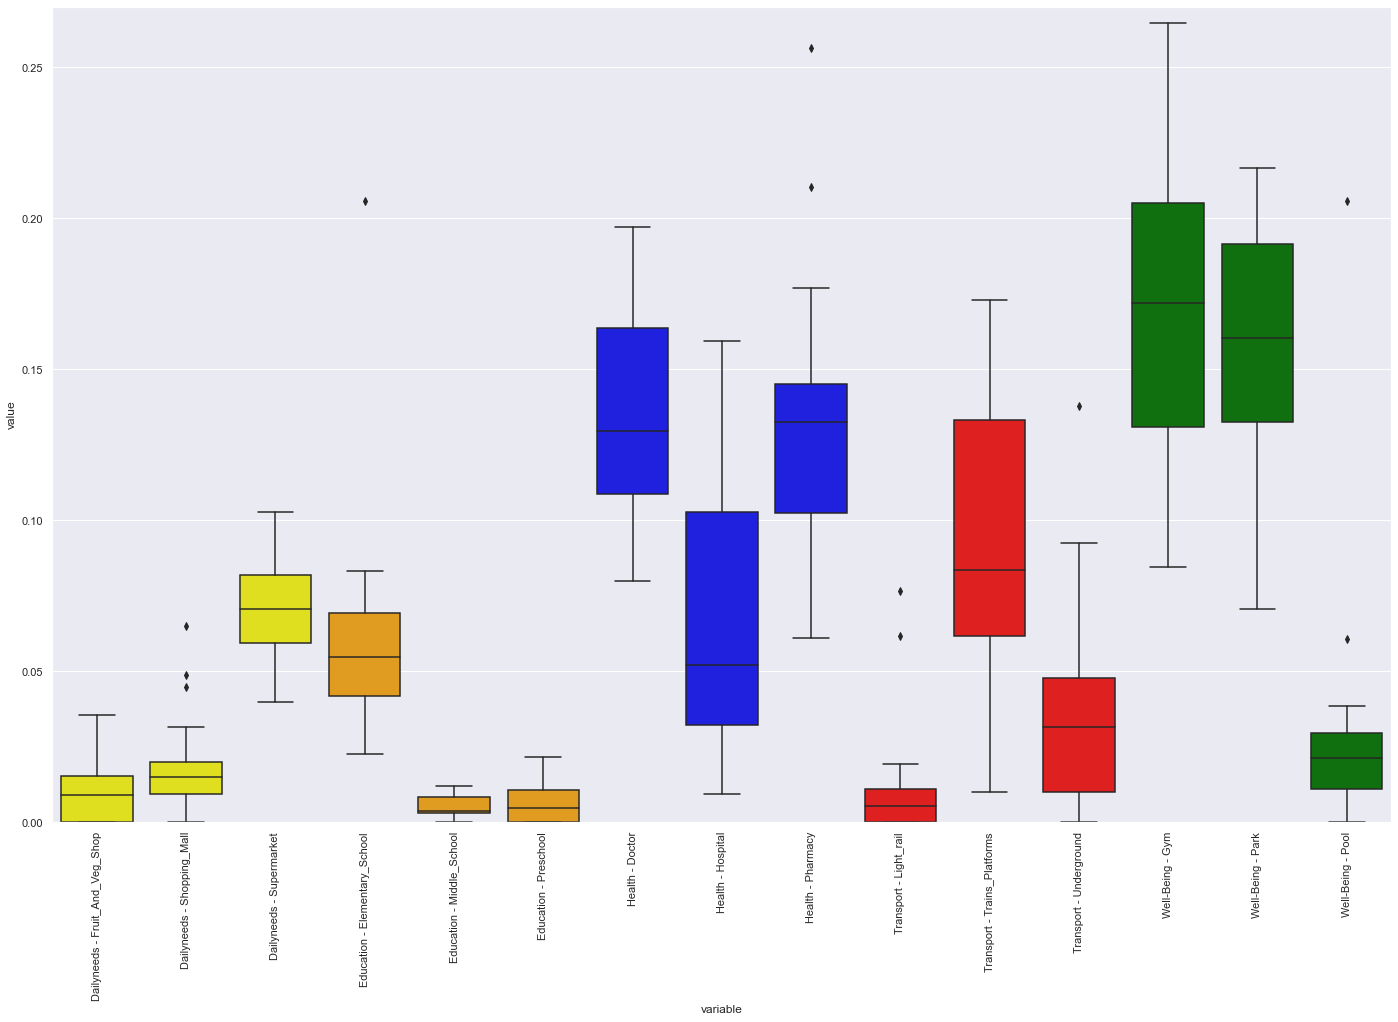

In [77]:
#Definition of the color codes similar to the ones used previously when displaying the venues in the london map. (Each Category group on basic color)
mypalette = {}
for i in borough_ratios.columns:
    mypalette[i]=category_color[i.split()[0]]
    
sns.set(rc={'figure.figsize':(24,15)})
ax = sns.boxplot(x="variable", y="value", data=pd.melt(borough_ratios), palette=mypalette)
ax.set(ylim=(0, 0.27))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)



We can see there are bigger differences between boroughs when we look at how many hospitals per 1000 people are in it. Gyms and Train platforms have also a big variance between neighbourhoods. All of them can make a big difference when deciding to live in one place or another.
On the other side, the number of Light trains, shopping malls and middle schools do not have a big range between the max and the min, therefore the impact when choosing a borough over other is not as important.


## Machine Learning Techniques used
In order to grouping similar neighbourhood, I have decided to use k-means clustering. Its simplicity makes it the perfect grouping technique for this purpose. As we are going to run several times (one for each group, and another with all the categories) it will be computationally faster.


In [78]:
#Redefinintion of boroughs ratios without flattening columns
borough_ratios=borough_data.div(london_population['Population'], axis=0)
borough_ratios=borough_ratios*1000



Group                          Dailyneeds                            \
Category               Fruit_And_Veg_Shop Shopping_Mall Supermarket   
Barking and Dagenham             0.000000      0.009394    0.056363   
Barnet                           0.017683      0.012630    0.078309   
Bexley                           0.012083      0.008055    0.084580   
Brent                            0.009097      0.009097    0.048519   
Bromley                          0.009027      0.012036    0.084252   
Camden                           0.022220      0.018517    0.070363   
City of London                   0.000000      0.514350    0.102870   
Croydon                          0.005172      0.010344    0.069820   
Ealing                           0.008777      0.020479    0.058513   
Enfield                          0.014979      0.014979    0.095868   
Greenwich                        0.010419      0.000000    0.069458   
Hackney                          0.035572      0.017786    0.081816   
Hammersmith and Fulham           0.000000      0.048611    0.059414   
Haringey                         0.011167      0.011167    0.078169   
Harrow                           0.000000      0.011945    0.075649   
Havering                         0.000000      0.019264    0.080909   
Hillingdon                       0.016294      0.016294    0.068433   
Hounslow                         0.018415      0.011049    0.073659   
Islington                        0.032994      0.020621    0.057740   
Kensington and Chelsea           0.000000      0.044835    0.064050   
Kingston upon Thames             0.000000      0.016901    0.090137   
Lambeth                          0.015336      0.015336    0.052142   
Lewisham                         0.003270      0.006539    0.081742   
Merton                           0.000000      0.004841    0.087147   
Newham                           0.000000      0.019823    0.039645   
Redbridge                        0.003276      0.006553    0.058973   
Richmond upon Thames             0.005050      0.000000    0.070700   
Southwark                        0.034501      0.031365    0.059593   
Sutton                           0.014538      0.014538    0.087231   
Tower Hamlets                    0.015397      0.027714    0.052349   
Waltham Forest                   0.003610      0.003610    0.061376   
Wandsworth                       0.006067      0.018200    0.078865   
Westminster                      0.015307      0.065055    0.084189   

Group                          Education                            Health  \
Category               Elementary_School Middle_School Preschool    Doctor   
Barking and Dagenham            0.065757      0.000000  0.000000  0.079847   
Barnet                          0.053048      0.010104  0.012630  0.166722   
Bexley                          0.044304      0.012083  0.008055  0.108745   
Brent                           0.039421      0.006065  0.009097  0.124329   
Bromley                         0.069207      0.003009  0.003009  0.129387   
Camden                          0.037033      0.003703  0.003703  0.107396   
City of London                  0.205740      0.000000  0.000000  1.234441   
Croydon                         0.041375      0.010344  0.002586  0.129296   
Ealing                          0.035108      0.002926  0.000000  0.163836   
Enfield                         0.041942      0.002996  0.011983  0.101859   
Greenwich                       0.052094      0.006946  0.013892  0.138917   
Hackney                         0.064030      0.003557  0.010672  0.096044   
Hammersmith and Fulham          0.059414      0.005401  0.021605  0.091821   
Haringey                        0.074447      0.000000  0.007445  0.111671   
Harrow                          0.043797      0.011945  0.000000  0.119446   
Havering                        0.077056      0.000000  0.003853  0.142553   
Hillingdon                      0.042363      0.006517  0.009776  0.133607   
Hounslow                        

In [95]:
#The next piece of code will run k-clusterion over each of the categories group
kclusters = 5
categories_cluster = pd.DataFrame() #Dataframe to store cluster info for each group
categories_cluster['Borough'] = borough_ratios.index
for group in borough_ratios.columns:
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(borough_ratios[group[0]])
    categories_cluster[group[0]] = kmeans.labels_
categories_cluster


Dailyneeds
Dailyneeds
Dailyneeds
Education
Education
Education
Health
Health
Health
Transport
Transport
Transport
Well-Being
Well-Being
Well-Being


Borough  Dailyneeds  Education  Health  Transport  \
0     Barking and Dagenham           3          3       2          2   
1                   Barnet           4          2       0          2   
2                   Bexley           4          4       2          2   
3                    Brent           3          4       2          2   
4                  Bromley           4          3       2          3   
5                   Camden           0          0       3          0   
6           City of London           1          1       1          1   
7                  Croydon           4          4       2          4   
8                   Ealing           3          0       0          2   
9                  Enfield           4          4       2          2   
10               Greenwich           4          2       0          3   
11                 Hackney           0          2       2          3   
12  Hammersmith and Fulham           2          2       3          0   
13                Haringey           4          3       2          2   
14                  Harrow           4          4       2          2   
15                Havering           4          3       2          2   
16              Hillingdon           0          4       0          2   
17                Hounslow           0          0       0          2   
18               Islington           0          3       0          3   
19  Kensington and Chelsea           2          3       4          0   
20    Kingston upon Thames           4          3       3          3   
21                 Lambeth           3          2       3          3   
22                Lewisham           4          3       2          4   
23                  Merton           4          4       0          3   
24                  Newham           3          0       2          4   
25               Redbridge           3          0       2          2   
26    Richmond upon Thames           4          2       0          4   
27               Southwark           0          4       3          3   
28                  Sutton           4          3       3          3   
29           Tower Hamlets           3          2       2          2   
30          Waltham Forest           3          0       2          2   
31              Wandsworth           4          2       3          3   
32             Westminster           2          2       4          0   

    Well-Being  
0            2  
1            0  
2            2  
3            2  
4            3  
5            0  
6            1  
7            2  
8            0  
9            2  
10           0  
11           2  
12           3  
13           0  
14           3  
15           2  
16           3  
17           0  
18           3  
19           3  
20           0  
21           0  
22           0  
23           0  
24           2  
25           2  
26           4  
27           3  
28           3  
29           0  
30           0  
31           0  
32           0

# 1 Results

Lets display the results for each categery in a map. 

In [126]:
group_maps = {}
groups_colour_schemes = {'Health': 'Blues', 'Transport': 'Reds', 'Well-Being': 'BuGn', 'Dailyneeds': 'YlOrBr', 'Education': 'Greys'} 
for group in categories_cluster.columns[1:]:
    group_maps[group] = folium.Map(location=[London_lat, London_lon], zoom_start=10, tiles='openstreetmap')

    group_maps[group].choropleth(
        geo_data='London_Boroughs_Boundaries.geojson',
        data=categories_cluster,
        columns=['Borough', group],
        key_on='feature.properties.lad17nm',
        fill_color=groups_colour_schemes[group], 
        fill_opacity=0.7, 
        line_opacity=0.9,
        legend_name='{} Clusters'.format(group)
    )
    group_maps[group]


In [122]:
group_maps['Health']


In [134]:
group_maps['Transport']

In [124]:
group_maps['Dailyneeds']

In [136]:
group_maps['Well-Being']

In [127]:
group_maps['Education']

Without considering any group, the results are as follows:


In [132]:
kclusters = 5
London_cluster = pd.DataFrame() #Dataframe to store cluster info for each group
London_cluster['Borough'] = borough_ratios.index
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(borough_ratios)
London_cluster['Cluster'] = kmeans.labels_
London_cluster_map = folium.Map(location=[London_lat, London_lon], zoom_start=10, tiles='openstreetmap')
London_cluster_map.choropleth(
        geo_data='London_Boroughs_Boundaries.geojson',
        data=London_cluster,
        columns=['Borough', 'Cluster'],
        key_on='feature.properties.lad17nm',
        fill_color='BuPu', 
        fill_opacity=0.7, 
        line_opacity=0.9,
        legend_name='Final Clusters'
)
London_cluster_map